# Restricted Boltzmann Machines in R

## MNIST Data-Set

Load the MNIST digit recognition dataset into R http://yann.lecun.com/exdb/mnist/
assume you have all 4 files and gunzip'd them creates train\$n, train\$x, train\$y  and test\$n, test\$x, test\$y
e.g. train\$x is a 60000 x 784 matrix, each row is one digit (28x28)
call:  show\_digit(train$x[5,]) to see a digit.

* Snippet authory: **Brendan O'Connor** - https://gist.github.com/39760 - anyall.org

In [1]:
load_mnist <- function()
{
    load_image_file <- function(filename)
    {
        ret = list();
        f = file(filename,'rb');
        readBin(f,'integer',n=1,size=4,endian='big');
        ret$n = readBin(f,'integer',n=1,size=4,endian='big');
        nrow = readBin(f,'integer',n=1,size=4,endian='big');
        ncol = readBin(f,'integer',n=1,size=4,endian='big');
        x = readBin(f,'integer',n=ret$n*nrow*ncol,size=1,signed=F);
        ret$x = matrix(x, ncol=nrow*ncol, byrow=T);
        close(f);
        ret;
    }
    load_label_file <- function(filename)
    {
        f = file(filename,'rb');
        readBin(f,'integer',n=1,size=4,endian='big');
        n = readBin(f,'integer',n=1,size=4,endian='big');
        y = readBin(f,'integer',n=n,size=1,signed=F);
        close(f);
        y;
    }
    train <<- load_image_file('./datasets/train-images.idx3-ubyte');
    test <<- load_image_file('./datasets/t10k-images.idx3-ubyte');

    train$y <<- load_label_file('./datasets/train-labels.idx1-ubyte');
    test$y <<- load_label_file('./datasets/t10k-labels.idx1-ubyte');
}

show_digit <- function(arr784, col=gray(12:1/12), ...)
{
    image(matrix(arr784, nrow=28)[,28:1], col=col, ...);
}

* Load **MNIST**
* Normalize: X = (X - min) / (max - min) => X = (X - 0) / (255 - 0) => X = X / 255.
* Setup training data with digit and pixel values with 60/40 split for train/cv.

In [2]:
train <- data.frame();
test <- data.frame();

load_mnist();

train$x <- train$x / 255;

inTrain <- data.frame(y=train$y, train$x);
inTrain$y <- as.factor(inTrain$y);
trainIndex <- sample(x=1:length(inTrain$y),size=length(inTrain$y) * 0.6);
training <- inTrain[trainIndex,];
cv <- inTrain[-trainIndex,];

Draw a Digit

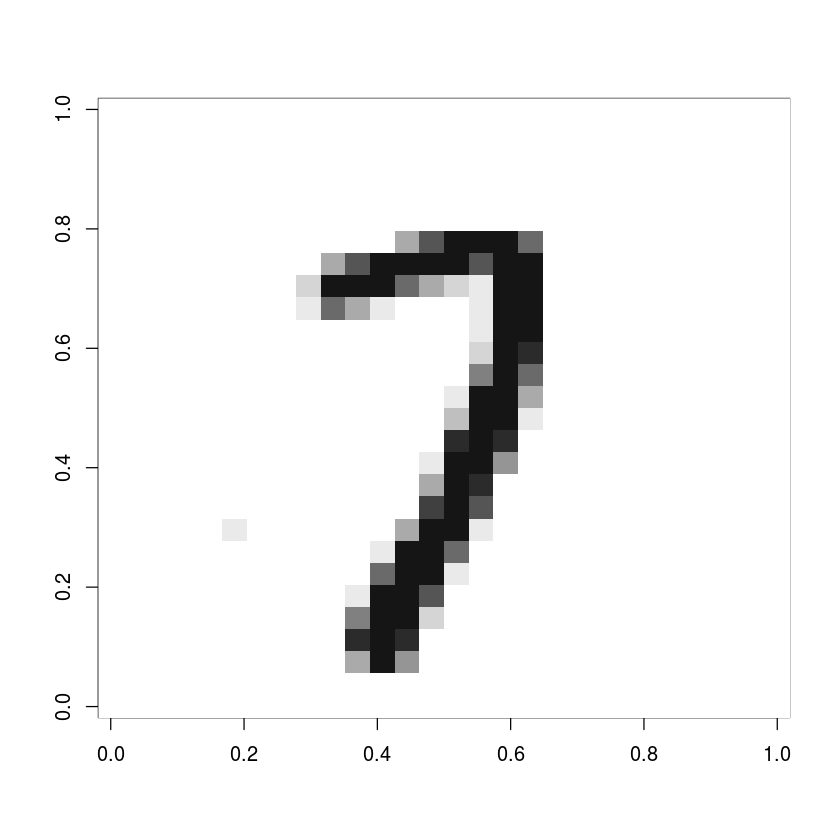

In [3]:
show_digit(as.matrix(training[5,2:785]))

In [4]:
# Requires caret and kernlab (from source better than deb)
library(caret)

Loading required package: lattice
Loading required package: ggplot2


Train a SVM and Predict a digit, then show

In [5]:
if (FALSE)
{
    opt.warn <- getOption("warn");
    options(warn = -1);

    # SVM. 95/94.
    fit <- train(y ~ ., data = head(training, 1000), method = 'svmRadial', tuneGrid = data.frame(sigma=0.0107249, C=1))
    results <- predict(fit, newdata = head(cv, 1000))
    confusionMatrix(results, head(cv$y, 1000))

    # Predict the digit.
    predict(fit, newdata = training[5,])

    # Check the actual answer for the digit.
    training[5,1]

    options(warn = opt.warn);
}

## RBM Implementation

Base Implementation:
* **Andrew Landgraf** from https://www.r-bloggers.com/restricted-boltzmann-machines-in-r/

### Functions

* rbm_w is a matrix of size <number of hidden units> by <number of visible units>
* visible_state is matrix of size <number of visible units> by <number of data cases>
* hidden_state is a binary matrix of size <number of hidden units> by <number of data cases>

In [6]:
visible_state_to_hidden_probabilities <- function(rbm_w, visible_state)
{
    1 / (1 + exp(-rbm_w %*% visible_state));
}
 
hidden_state_to_visible_probabilities <- function(rbm_w, hidden_state)
{
    1 / (1 + exp(-t(rbm_w) %*% hidden_state));
}
 
configuration_goodness <- function(rbm_w, visible_state, hidden_state)
{
    out <- 0;
    for (i in 1:dim(visible_state)[2])
    {
        out <- out + t(hidden_state[,i]) %*% rbm_w %*% visible_state[,i];
    }
    out / dim(visible_state)[2];
}
 
configuration_goodness_gradient <- function(visible_state, hidden_state)
{
    hidden_state %*% t(visible_state) / dim(visible_state)[2];
}
 
sample_bernoulli <- function(mat)
{
    dims <- dim(mat);
    array(rbinom(n = prod(dims), size = 1, prob = c(mat)), dims);
}

__cd1__ is a function that takes parameters __model__ and __data__ and returns the gradient (or approximate gradient in the case of CD-1) of the function that we're maximizing. The returned gradient is an array of the same shape as the provided __model__ parameter.

In [7]:
cd1 <- function(rbm_w, visible_data)
{
    visible_data <- sample_bernoulli(visible_data);
    
    H0 <- sample_bernoulli(visible_state_to_hidden_probabilities(rbm_w, visible_data));
    vh0 <- configuration_goodness_gradient(visible_data, H0);
    V1 <- sample_bernoulli(hidden_state_to_visible_probabilities(rbm_w, H0));
    H1 <- visible_state_to_hidden_probabilities(rbm_w, V1);

    vh1 <- configuration_goodness_gradient(V1, H1);
    vh0 - vh1;
}

This trains a model that is defined by a single matrix of weights.

* __num_hidden__ is the number of hidden units
*   This uses mini-batches, no weight decay and no early stopping.
*   This returns the matrix of weights of the trained model.

In [8]:
rbm <- function(num_hidden, training_data, learning_rate, n_iterations, mini_batch_size=100, momentum=0.9, quiet=FALSE)
{
    n <- dim(training_data)[2];
    p <- dim(training_data)[1];
    if (n %% mini_batch_size != 0) stop("the number of test cases must be divisable by the mini_batch_size");
            
    model <- (matrix(runif(num_hidden*p),num_hidden,p) * 2 - 1) * 0.1;
    momentum_speed <- matrix(0, num_hidden, p);

    start_of_next_mini_batch <- 1;
    for (iteration_number in 1:n_iterations)
    {
        if (!quiet) cat("Iter", iteration_number, "\n");

        mini_batch <- training_data[, start_of_next_mini_batch:(start_of_next_mini_batch + mini_batch_size - 1)];
        start_of_next_mini_batch <- (start_of_next_mini_batch + mini_batch_size) %% n;
        gradient <- cd1(model, mini_batch);
        momentum_speed <- momentum * momentum_speed + gradient;
        model <- model + momentum_speed * learning_rate;
    }
    return(model);
}

### Perform RBM training

For some reason, can't convert everything to numeric by rows or columns...

In [9]:
training.num <- t(apply(training,1,function(x) sapply(x,function(y) as.numeric(y))))

In [10]:
training.num[1:3,]

,y,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X775,X776,X777,X778,X779,X780,X781,X782,X783,X784
27392,9,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
56742,3,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
37738,9,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [11]:
weights <- rbm(
    num_hidden = 30,
    training_data = t(training.num)[2:785,],
    learning_rate = 1e-1,
    n_iterations = 5000,
    mini_batch_size = 100,
    momentum = 0.2,
    quiet = TRUE
);

In [61]:
library(ggplot2);
library(reshape2);

In [62]:
mw <- melt(weights);
mw$Var3 <- floor((mw$Var2 - 1)/28) + 1;
mw$Var2 <- (mw$Var2 - 1) %% 28 + 1;
mw$Var3 <- 29 - mw$Var3;

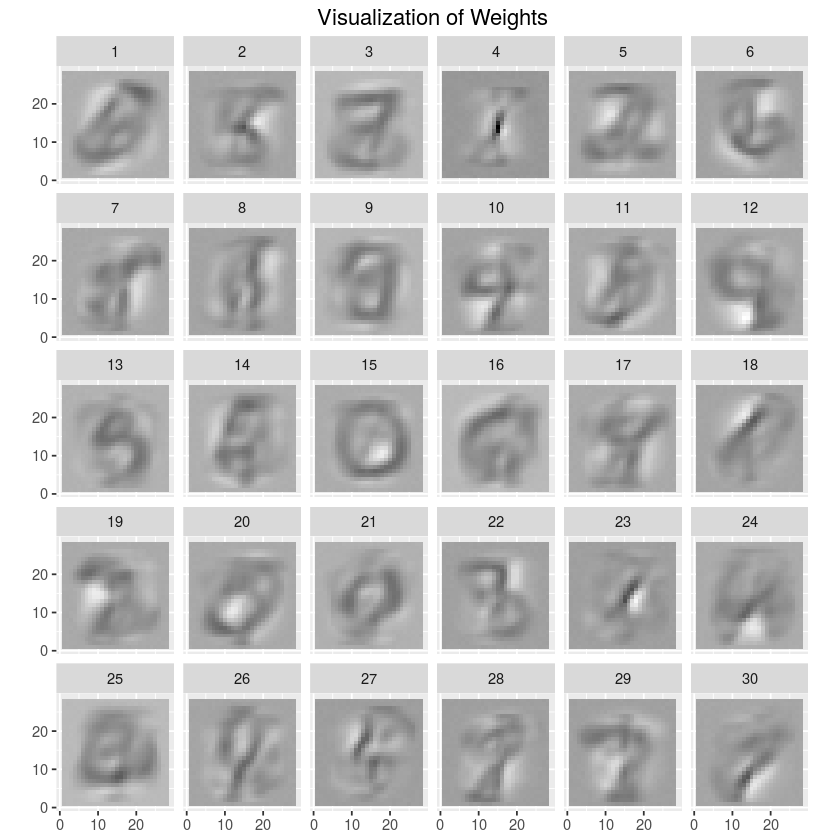

In [63]:
ggplot(data = mw) +
geom_tile(aes(Var2, Var3, fill = value)) +
facet_wrap(~Var1, nrow = 5) +
scale_fill_continuous(low = 'white', high = 'black') +
coord_equal() +
labs(x = NULL, y = NULL, title = "Visualization of Weights") +
theme(legend.position = "none")

### Prediction and Reconstruction

Reconstruction of all the data-set, to see how the RBM sees each number.

Note: The reconstruction bias is computed a-posteriori to simplify

In [64]:
# Reconstruction
rec.input <-  t(weights) %*% (weights %*% t(training.num)[2:785,]);

# Quick Bias Estimation A-Posteriori, for reconstruction
bias <- rowMeans(t(training.num)[2:785,] - rec.input);
rec.input <- rec.input + bias;

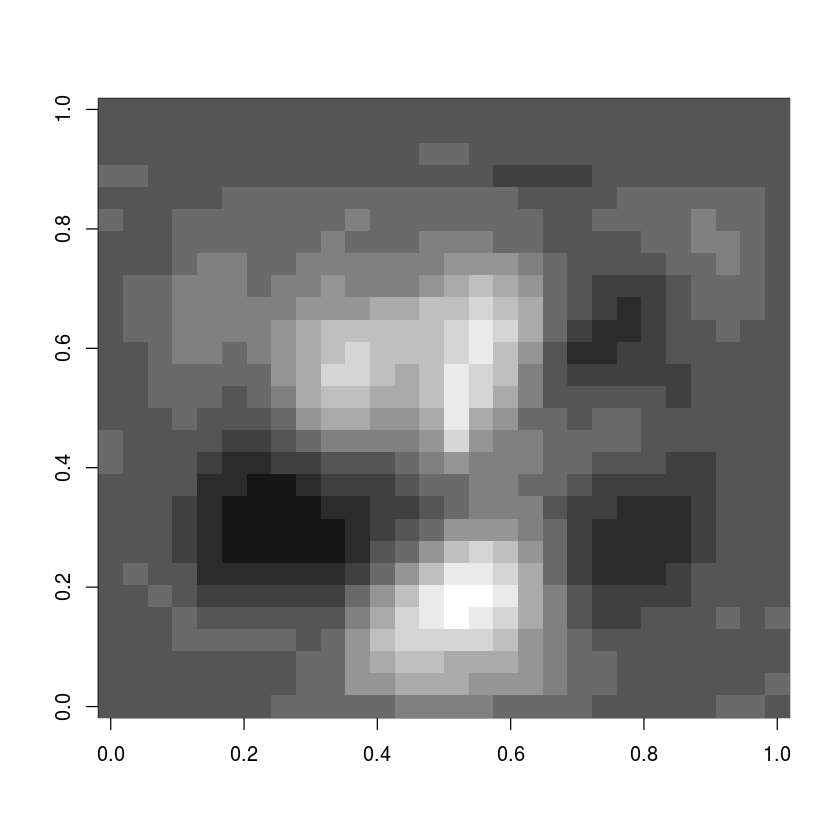

In [65]:
show_digit(as.matrix(rec.input[,5]))